In [1]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from matplotlib import patches

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import Compose, ToTensor, Resize

from os.path import join, isdir
from os import listdir, mkdir
from shutil import copyfile, move

import json
from tqdm import tqdm

np.random.seed(42)

In [2]:
path = '/home/egor/job/CAPTCHA_recognition/data/captchas_fns'

# Data loading

Manually labeled data

In [3]:
df = pd.read_csv(join(path, 'captchas_labeled', 'labels.csv'))

In [4]:
df.head()

,#filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,0.png,1502,{},6,0,"{""name"":""rect"",""x"":30,""y"":26,""width"":31,""heigh...","{""label"":""1""}"
1,0.png,1502,{},6,1,"{""name"":""rect"",""x"":57,""y"":29,""width"":24,""heigh...","{""label"":""4""}"
2,0.png,1502,{},6,2,"{""name"":""rect"",""x"":78,""y"":29,""width"":25,""heigh...","{""label"":""9""}"
3,0.png,1502,{},6,3,"{""name"":""rect"",""x"":98,""y"":25,""width"":35,""heigh...","{""label"":""9""}"
4,0.png,1502,{},6,4,"{""name"":""rect"",""x"":127,""y"":22,""width"":33,""heig...","{""label"":""5""}"


In [5]:
proc_df = pd.DataFrame()

proc_df['cord_dict'] = df['region_shape_attributes'].apply(lambda x: json.loads(x))

proc_df['img_name'] = df['#filename']
proc_df['region_id'] = df['region_id']
proc_df['x0'] = proc_df['cord_dict'].apply(lambda x: x['x'])
proc_df['y0'] = proc_df['cord_dict'].apply(lambda x: x['y'])
proc_df['x1'] = proc_df.apply(lambda row: row['x0'] + row['cord_dict']['width'], axis=1)
proc_df['y1'] = proc_df.apply(lambda row: row['y0'] + row['cord_dict']['height'], axis=1)
proc_df['w'] = proc_df['cord_dict'].apply(lambda x: x['width'])
proc_df['h'] = proc_df['cord_dict'].apply(lambda x: x['height'])
proc_df['label'] = df['region_attributes'].apply(lambda x: json.loads(x)['label'])

proc_df = proc_df.drop(['cord_dict'], axis=1)

proc_df.head()

,img_name,region_id,x0,y0,x1,y1,w,h,label
0,0.png,0,30,26,61,71,31,45,1
1,0.png,1,57,29,81,73,24,44,4
2,0.png,2,78,29,103,72,25,43,9
3,0.png,3,98,25,133,71,35,46,9
4,0.png,4,127,22,160,73,33,51,5


In [6]:
proc_df['img_name'].nunique()

193

Auto labeled data

In [7]:
df2 = pd.read_csv(join(path, 'captchas_labeled', 'auto_labeled_labels.csv'))

In [8]:
df2.head()

,img_name,region_id,x0,y0,x1,y1,w,h,label
0,5814.png,0,49,30,92,78,43,48,9
1,5814.png,1,128,27,155,77,27,50,5
2,5814.png,2,101,31,133,76,32,45,2
3,5814.png,3,30,32,54,81,24,49,1
4,5814.png,4,83,32,108,71,25,39,7


In [9]:
df2['img_name'].nunique()

126

Combine data

In [10]:
proc_df = pd.concat([proc_df, df2], axis=0)
proc_df.head()

,img_name,region_id,x0,y0,x1,y1,w,h,label
0,0.png,0,30,26,61,71,31,45,1
1,0.png,1,57,29,81,73,24,44,4
2,0.png,2,78,29,103,72,25,43,9
3,0.png,3,98,25,133,71,35,46,9
4,0.png,4,127,22,160,73,33,51,5


In [11]:
proc_df['img_name'].nunique()

319

In [12]:
proc_df['label'] = proc_df['label'].apply(lambda x: str(x))

Distribution of numbers

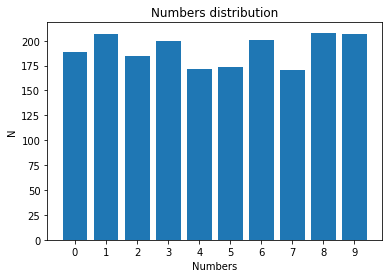

In [13]:
num_freq = proc_df['label'].value_counts()
num_freq = [(k, v) for k, v in zip(num_freq.keys(), num_freq.values)]
num_freq = sorted(num_freq, key=lambda x: x[0])

plt.bar(range(len(num_freq)), [i[1] for i in num_freq], align='center')
plt.xticks(range(len(num_freq)), [i[0] for i in num_freq])
plt.xlabel('Numbers')
plt.ylabel('N')
plt.title('Numbers distribution')
plt.show()

# Deep learning

## Data handling

In [14]:
np.random.seed(42)

if not isdir(join(path, 'train')):
    mkdir(join(path, 'train'))
if not isdir(join(path, 'val')):
    mkdir(join(path, 'val'))
    
img_names = [name for name in listdir(join(path, 'captchas_labeled')) if '.png' in name]

n_train = int(0.85 * len(img_names))
indices = np.random.permutation(len(img_names))
img_names = [img_names[i] for i in indices]

train_images = img_names[:n_train]
val_images = img_names[n_train:]

for name in train_images:
    copyfile(join(path, 'captchas_labeled', name), join(path, 'train', name))

for name in val_images:
    copyfile(join(path, 'captchas_labeled', name), join(path, 'val', name))
    
train_df = proc_df[proc_df['img_name'].isin(train_images)]
val_df = proc_df[proc_df['img_name'].isin(val_images)]

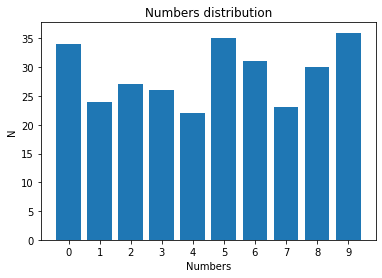

In [15]:
num_freq = val_df['label'].value_counts()
num_freq = [(k, v) for k, v in zip(num_freq.keys(), num_freq.values)]
num_freq = sorted(num_freq, key=lambda x: x[0])

plt.bar(range(len(num_freq)), [i[1] for i in num_freq], align='center')
plt.xticks(range(len(num_freq)), [i[0] for i in num_freq])
plt.xlabel('Numbers')
plt.ylabel('N')
plt.title('Numbers distribution')
plt.show()

In [16]:
class Vocab():

    def __init__(self, df):
        
        self.vocab = sorted(df['label'].unique())
        self.tok2int = {tok: i for i, tok in enumerate(self.vocab)}
        self.int2tok = {i: tok for tok, i in self.tok2int.items()}
        
    def __len__(self):
        return len(self.vocab)

Images are so small so it's possible to keep them in memory and don't spend time on reading them from disk

In [17]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_path, df, vocab, transform_func):
        
        self.df = df
        self.img_names = self.df['img_name'].unique()
        self.vocab = vocab
        self.transform_func = transform_func
        
        imgs = []
        for name in self.img_names:
            imgs.append(plt.imread(join(data_path, name))[:,:,:3])
            
        self.images = np.stack(imgs)
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, indx):
        cur_name = self.img_names[indx]
        
        img = self.images[indx]
        boxes, labels = [], []
        
        cur_df = self.df[self.df['img_name'] == cur_name]
        for i, row in cur_df.iterrows():
            boxes.append([row['x0'], row['y0'], row['x1'], row['y1']])
            labels.append(self.vocab.tok2int[row['label']])
        
        img, boxes, labels = self.transform_func(img, boxes, labels)
        
        target = {'boxes': boxes, 'labels': labels}
        
        return img, target
    
def custom_collate(batch):
    imgs = [i[0] for i in batch]
    targets = [i[1] for i in batch]
    
    return imgs, targets

In [18]:
# code was taken from https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py

def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)


def random_crop(image, boxes, labels):
    """
    Performs a random crop in the manner stated in the paper. Helps to learn to detect larger and partial objects.
    Note that some objects may be cut out entirely.
    Adapted from https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :return: cropped image, updated bounding box coordinates, updated labels
    """
    original_h = image.size(1)
    original_w = image.size(2)
    # Keep choosing a minimum overlap until a successful crop is made
    while True:
        # Randomly draw the value for minimum overlap
        min_overlap = random.choice([0., .1, .3, .5, .7, .9, None])  # 'None' refers to no cropping

        # If not cropping
        if min_overlap is None:
            return image, boxes, labels
        
        # Try up to 50 times for this choice of minimum overlap
        # This isn't mentioned in the paper, of course, but 50 is chosen in paper authors' original Caffe repo
        max_trials = 50
        for _ in range(max_trials):
            # Crop dimensions must be in [0.3, 1] of original dimensions
            # Note - it's [0.1, 1] in the paper, but actually [0.3, 1] in the authors' repo
            min_scale = 0.5
            scale_h = random.uniform(min_scale, 1)
            scale_w = random.uniform(min_scale, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)

            # Aspect ratio has to be in [0.5, 2]
            aspect_ratio = new_h / new_w
            if not 0.5 < aspect_ratio < 2:
                continue

            # Crop coordinates (origin at top-left of image)
            left = random.randint(0, original_w - new_w)
            right = left + new_w
            top = random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Calculate Jaccard overlap between the crop and the bounding boxes
            overlap = find_jaccard_overlap(crop.unsqueeze(0),
                                           boxes)  # (1, n_objects), n_objects is the no. of objects in this image
            overlap = overlap.squeeze(0)  # (n_objects)

            # If not a single bounding box has a Jaccard overlap of greater than the minimum, try again
            if overlap.max().item() < min_overlap:
                continue

            # Crop image
            new_image = image[:, top:bottom, left:right]  # (3, new_h, new_w)

            # Find centers of original bounding boxes
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)

            # Find bounding boxes whose centers are in the crop
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (
                    bb_centers[:, 1] < bottom)  # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index

            # If not a single bounding box has its center in the crop, try again
            if not centers_in_crop.any():
                continue

            # Discard bounding boxes that don't meet this criterion
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]

            # Calculate bounding boxes' new coordinates in the crop
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
            new_boxes[:, 2:] -= crop[:2]
            
            return new_image, new_boxes, new_labels
        

def sp_noise(img, pepper=0.01, salt=0.01):
    h, w, c = img.shape
    
    pepper, salt = pepper * 100, (1 - salt) * 100
    
    noise = np.random.randint(100, size = (h, w, 1))
    img = np.where(noise < pepper, 0, img)
    img = np.where(noise > salt, 1, img)
    
    return img

In [19]:
def no_transform(img, boxes, labels):
    
    img = torch.FloatTensor(img).permute(2,0,1)
    boxes = torch.FloatTensor(boxes)
    labels = torch.LongTensor(labels)
    
    return img, boxes, labels


def transforms(img, boxes, labels):
    
    if random.rand() > 0.5:
        pepper_perc = random.choice([.01, .02, .03])
        salt_perc = random.choice([.05, .07, .09])
        img = sp_noise(img, pepper_perc, salt_perc)
    
    img = torch.FloatTensor(img).permute(2,0,1)
    boxes = torch.FloatTensor(boxes)
    labels = torch.LongTensor(labels)

    img, boxes, labels = random_crop(img, boxes, labels)
    
    return img, boxes, labels

In [20]:
from transforms.transforms import Compose, BoxesToCoords, ElasticTransform, RandomRotate, \
                                  Expand, CoordsToBoxes, RandomShift

class SaltPapper(object):
    def __init__(self, pepper=0.01, salt=0.01, prob=0.5, random=np.random):

        self.pepper = pepper
        self.salt = salt
        self.prob = prob
        self.random = random

    def __call__(self, img, cds=None):
        h, w, c = img.shape
        pepper, salt = self.pepper * 100, (1 - self.salt) * 100
        
        if self.random.rand() > self.prob:
            return img, cds

        noise = self.random.randint(100, size = (h, w, 1))
        img = np.where(noise < pepper, 0, img)
        img = np.where(noise > salt, 1, img)
        
        return img, cds

tr = Compose([           
        BoxesToCoords(relative=False),
        ElasticTransform(150, 15, 0.5, fillval=1),
        RandomShift((-0.05, 0.05), fillval=1),
        RandomRotate(10, fillval=1),
        Expand((0.7, 1.2), fillval=1),
        SaltPapper(0.03, 0.07),
        CoordsToBoxes(relative=False),
    ], 
    mode='linear', 
    border='constant', 
    outside_points='clamp')

def new_transforms(img, boxes, labels):
    
    tr_img, tr_boxes = tr(img, boxes)
    
    # find box indices to remove
    # simple remove if ratio of number is changed considerably more than others
    chng_ratios = []
    for box, tr_box in zip(boxes, tr_boxes):
        x0, y0, x1, y1 = box
        tr_x0, tr_y0, tr_x1, tr_y1 = tr_box
        chng_ratios.append(((x1 - x0) * (y1 - y0)) / ((tr_x1 - tr_x0) * (tr_y1 - tr_y0)))
    med_rat = np.median(chng_ratios)
    ind2remove = np.where((np.array(chng_ratios) - med_rat) > med_rat / 1.7)
    
    tr_boxes = np.delete(tr_boxes, ind2remove, 0)
    tr_labels = np.delete(labels, ind2remove)
    
    tr_img = torch.FloatTensor(tr_img).permute(2,0,1)
    tr_boxes = torch.FloatTensor(tr_boxes)
    tr_labels = torch.LongTensor(tr_labels)
    
    return tr_img, tr_boxes, tr_labels    

In [21]:
vocab = Vocab(train_df)

In [22]:
train_dataset = CAPTCHADataset(join(path, 'train'), train_df, vocab, new_transforms)
val_dataset = CAPTCHADataset(join(path, 'val'), val_df, vocab, no_transform)

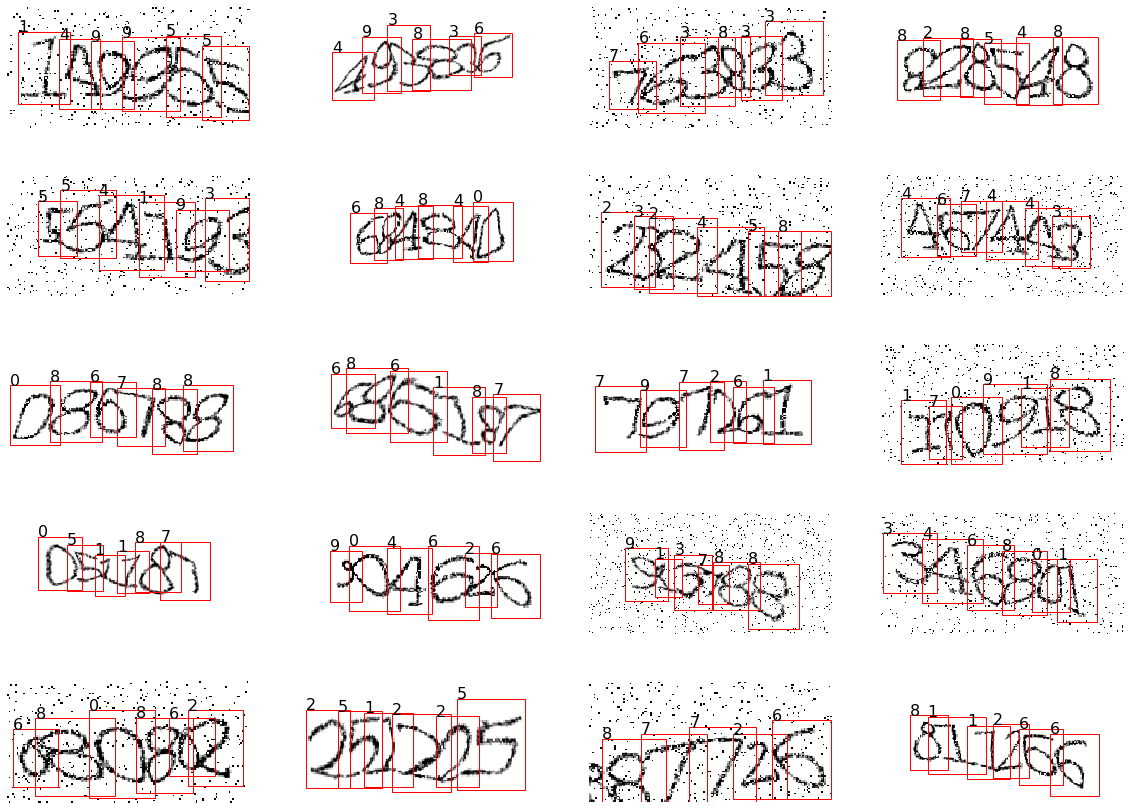

In [23]:
f, ax = plt.subplots(5, 4, figsize=(20, 15))

for i in range(20):
    img, targets = train_dataset[i]
    boxes, labels = targets['boxes'], targets['labels']
    
    img = img.squeeze().permute(1,2,0).numpy()
    boxes = boxes.numpy()
    labels = labels.numpy()
    
    r, c = i // 4, i % 4
    ax[r][c].imshow(img, cmap='gray')
    
    for (x0, y0, x1, y1), lbl in zip(boxes, labels):
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax[r][c].add_patch(rect)
        ax[r][c].text(x0, y0, lbl, fontsize=16)
        ax[r][c].axis('off')
plt.show()

## Training

In [24]:
def get_model(n_labels):
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_labels)
    
    return model

In [25]:
def train(model, loader, optimizer, epoch=None, lr_scheduler=None, batches_before_opt_step=1):
    model.train()
    
    if epoch: tqdm_text = f'Training {epoch} epoch'
    else:  tqdm_text = f'Training'
        
    epoch_loss = 0.
    cntr = 0
    for images, targets in tqdm(loader, desc=tqdm_text):
        cntr += 1
        images = [img.cuda() for img in images]
        targets = [{'boxes': t['boxes'].cuda(), 'labels': t['labels'].cuda()} for t in targets]
        
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        loss.backward()
        
        if cntr == batches_before_opt_step:
            cntr = 0
            optimizer.step()
            optimizer.zero_grad()
            
        
        if lr_scheduler:
            lr_scheduler.step()
            
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)


def evaluate(model, loader, epoch=None):
    # model has complicated set of losses so I wont calculate them myself
    # loss_dict is only returned in train mode thats why I use train mode
    # in evaluation function
    model.train()
    
    if epoch: tqdm_text = f'Evaluating {epoch} epoch'
    else:  tqdm_text = f'Evaluating'
    
    epoch_loss = 0.
    with torch.no_grad():
        for images, targets in tqdm(loader, desc=tqdm_text):
            
            images = [img.cuda() for img in images]
            targets = [{'boxes': t['boxes'].cuda(), 'labels': t['labels'].cuda()} for t in targets]
            
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

In [26]:
config = dict(
    epochs = 150,
    bs = 4,
)

vocab = Vocab(train_df)

train_dataset = CAPTCHADataset(join(path, 'train'), train_df, vocab, new_transforms)
val_dataset = CAPTCHADataset(join(path, 'val'), val_df, vocab, no_transform)

train_loader = DataLoader(train_dataset, config['bs'], collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, config['bs'], collate_fn=custom_collate)

In [27]:
model = get_model(len(vocab))
model.cuda()

param_groups = [
    {'params': model.backbone.body.conv1.parameters()},
    {'params': model.backbone.body.layer1.parameters()},
    {'params': model.backbone.body.layer2.parameters()},
    {'params': model.backbone.body.layer3.parameters()},
    {'params': model.backbone.body.layer4.parameters()},
    {'params': model.backbone.fpn.parameters()},
    {'params': model.rpn.head.parameters()},
    {'params': model.roi_heads.parameters()}
]

# optimizer = torch.optim.AdamW(param_groups, lr=1e-3)
optimizer = torch.optim.RAdam(param_groups, lr=1e-3)

In [28]:
for group in optimizer.param_groups[:-1]:
    for param in group['params']:
        param.requires_grad = False
        
for param in optimizer.param_groups[-1]['params']:
    param.requires_grad = True

In [29]:
train_loss = train(model, train_loader, optimizer)
val_loss = evaluate(model, val_loader)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'models/iter3_0_fns_head_trained_new_transforms.ptr')

print('train loss {:.4f}, val loss {:.4f}'.format(train_loss, val_loss))

Training:   1%|▏         | 1/68 [00:00<00:40,  1.65it/s]


KeyboardInterrupt: 

In [29]:
model.load_state_dict(torch.load('models/iter3_0_fns_head_trained_new_transforms.ptr')['model_state_dict'])
optimizer.load_state_dict(torch.load('models/iter3_0_fns_head_trained_new_transforms.ptr')['optimizer_state_dict'])

In [32]:
base_lr = 1e-4

def lr_update(n, base_lr):
    # epochs are counted from 0
    return base_lr * 0.7 ** n

for i, group in enumerate(optimizer.param_groups[::-1]):
    cur_lr = lr_update(i, base_lr)
    group['lr'] = cur_lr

In [33]:
for group in optimizer.param_groups:
    print(group['lr'])

8.235429999999996e-06
1.1764899999999996e-05
1.6806999999999993e-05
2.4009999999999995e-05
3.4299999999999993e-05
4.9e-05
7e-05
0.0001


In [34]:
for param in model.parameters():
    param.requires_grad = True

In [35]:
# increased no_improvement and early_stop_cntr and resumed training
model.load_state_dict(torch.load('models/iter3_0_best_fns_new_transforms.ptr')['model_state_dict'])
optimizer.load_state_dict(torch.load('models/iter3_0_best_fns_new_transforms.ptr')['optimizer_state_dict'])

In [36]:
best_loss = 0.1626
no_improvement = 0
early_stop_cntr = 0
for epoch in range(150):
    
    train_loss = train(model, train_loader, optimizer, epoch=epoch+1)
    val_loss = evaluate(model, val_loader, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
        early_stop_cntr = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'models/iter3_0_best_fns_new_transforms.ptr')
    else:
        if no_improvement > 10:
            print('Lr decreased by 0.5')
            for group in optimizer.param_groups:
                group['lr'] = group['lr'] * 0.5
            no_improvement = 0
        elif early_stop_cntr > 25:
            print('Early stopped')
            print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))
            break
        else:
            no_improvement += 1
            early_stop_cntr += 1
    
    print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))

Training 2 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

1: train loss 0.1845, val loss 0.1644


Training 3 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

2: train loss 0.1736, val loss 0.1641


Training 4 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

3: train loss 0.1715, val loss 0.1707


Training 5 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

4: train loss 0.1794, val loss 0.1708


Training 6 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

5: train loss 0.1752, val loss 0.1640


Training 7 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

6: train loss 0.1780, val loss 0.1669


Training 8 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

7: train loss 0.1736, val loss 0.1619


Training 9 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

8: train loss 0.1834, val loss 0.1611


Training 10 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

9: train loss 0.1800, val loss 0.1614


Training 11 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

10: train loss 0.1699, val loss 0.1689


Training 12 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

11: train loss 0.1755, val loss 0.1716


Training 13 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

12: train loss 0.1666, val loss 0.1659


Training 14 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

13: train loss 0.1715, val loss 0.1659


Training 15 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

14: train loss 0.1725, val loss 0.1654


Training 16 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

15: train loss 0.1736, val loss 0.1648


Training 17 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

16: train loss 0.1745, val loss 0.1691


Training 18 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

17: train loss 0.1805, val loss 0.1740


Training 19 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

18: train loss 0.1738, val loss 0.1712


Training 20 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

19: train loss 0.1721, val loss 0.1721


Training 21 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

Lr decreased by 0.5
20: train loss 0.1675, val loss 0.1691


Training 22 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

21: train loss 0.1653, val loss 0.1637


Training 23 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

22: train loss 0.1669, val loss 0.1638


Training 24 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

23: train loss 0.1629, val loss 0.1663


Training 25 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

24: train loss 0.1696, val loss 0.1591


Training 26 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

25: train loss 0.1621, val loss 0.1621


Training 27 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

26: train loss 0.1685, val loss 0.1637


Training 28 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

27: train loss 0.1632, val loss 0.1701


Training 29 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

28: train loss 0.1648, val loss 0.1681


Training 30 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

29: train loss 0.1566, val loss 0.1657


Training 31 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

30: train loss 0.1598, val loss 0.1628


Training 32 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

31: train loss 0.1622, val loss 0.1665


Training 33 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

32: train loss 0.1591, val loss 0.1623


Training 34 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

33: train loss 0.1573, val loss 0.1630


Training 35 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

34: train loss 0.1591, val loss 0.1658


Training 36 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

35: train loss 0.1574, val loss 0.1647


Training 37 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

Lr decreased by 0.5
36: train loss 0.1588, val loss 0.1721


Training 38 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

37: train loss 0.1671, val loss 0.1668


Training 39 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

38: train loss 0.1600, val loss 0.1668


Training 40 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

39: train loss 0.1567, val loss 0.1694


Training 41 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

40: train loss 0.1644, val loss 0.1630


Training 42 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

41: train loss 0.1587, val loss 0.1684


Training 43 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

42: train loss 0.1552, val loss 0.1665


Training 44 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

43: train loss 0.1580, val loss 0.1687


Training 45 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

44: train loss 0.1496, val loss 0.1665


Training 46 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

45: train loss 0.1571, val loss 0.1600


Training 47 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

46: train loss 0.1519, val loss 0.1644


Training 48 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

47: train loss 0.1531, val loss 0.1670


Training 49 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

Lr decreased by 0.5
48: train loss 0.1484, val loss 0.1695


Training 50 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

49: train loss 0.1529, val loss 0.1660


Training 51 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

50: train loss 0.1485, val loss 0.1598


Training 52 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

51: train loss 0.1455, val loss 0.1598


Training 53 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

52: train loss 0.1514, val loss 0.1617


Evaluating 53 epoch: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]

Early stopped
53: train loss 0.1494, val loss 0.1662


In [42]:
model.load_state_dict(torch.load('models/iter3_best_fns_transforms.ptr')['model_state_dict'])
optimizer.load_state_dict(torch.load('models/iter3_best_fns_transforms.ptr')['optimizer_state_dict'])

In [43]:
optimizer = torch.optim.RAdam(param_groups, lr=1e-3)

In [44]:
# base_lr = 1e-4

def lr_update(n, base_lr):
    # epochs are counted from 0
    return base_lr * 0.5 ** n

for i, group in enumerate(optimizer.param_groups[::-1]):
    cur_lr = lr_update(i, base_lr)
    group['lr'] = cur_lr

In [45]:
best_loss = 0.12
for epoch in range(15):
    
    train_loss = train(model, train_loader, optimizer, epoch=epoch+1)
    val_loss = evaluate(model, val_loader, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'models/iter3_best_fns_transforms_2.ptr')
    
    print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))

Training 1 epoch:  97%|█████████▋| 66/68 [01:18<00:02,  1.19s/it]

RuntimeError: CUDA out of memory. Tried to allocate 264.00 MiB (GPU 0; 7.93 GiB total capacity; 6.03 GiB already allocated; 65.81 MiB free; 789.86 MiB cached)

In [42]:
model.load_state_dict(torch.load('models/iter3_best_fns_transforms.ptr')['model_state_dict'])
optimizer.load_state_dict(torch.load('models/iter3_best_fns_transforms.ptr')['optimizer_state_dict'])

In [43]:
optimizer = torch.optim.RAdam(param_groups, lr=1e-3)

In [44]:
# base_lr = 1e-4

def lr_update(n, base_lr):
    # epochs are counted from 0
    return base_lr * 0.5 ** n

for i, group in enumerate(optimizer.param_groups[::-1]):
    cur_lr = lr_update(i, base_lr)
    group['lr'] = cur_lr

In [45]:
best_loss = 0.12
for epoch in range(15):
    
    train_loss = train(model, train_loader, optimizer, epoch=epoch+1)
    val_loss = evaluate(model, val_loader, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'models/iter3_best_fns_transforms_2.ptr')
    
    print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))

Training 1 epoch:  97%|█████████▋| 66/68 [01:18<00:02,  1.19s/it]

RuntimeError: CUDA out of memory. Tried to allocate 264.00 MiB (GPU 0; 7.93 GiB total capacity; 6.03 GiB already allocated; 65.81 MiB free; 789.86 MiB cached)

# Predictions

In [25]:
def get_prediction(img_path, model, threshold):
    img = plt.imread(img_path)[:,:,:3]
    img = torch.FloatTensor(img).permute(2,0,1).cuda()
    pred = model([img])
    pred_class = [vocab.int2tok[i] for i in list(pred[0]['labels'].detach().cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    return pred_boxes, pred_class, pred_score

In [26]:
model = get_model(len(vocab))
model.cuda();

In [27]:
model.load_state_dict(torch.load('models/iter3_best_fns_transforms.ptr')['model_state_dict'])

<All keys matched successfully>

In [28]:
model.eval();

In [29]:
get_prediction(join(path, 'captchas_unlabeled', '101.png'), model, 0.8)

([[(47.065804, 23.730608), (85.80222, 74.47728)],
  [(82.10363, 18.389091), (120.78683, 72.07235)],
  [(143.5477, 21.054274), (176.44081, 68.60526)],
  [(16.523533, 28.453812), (49.666298, 71.718796)],
  [(128.45569, 26.931465), (149.71553, 65.25805)]],
 ['1', '6', '5', '5', '2'],
 [0.99983394, 0.99978095, 0.9970066, 0.9964334, 0.98909175])

In [30]:
test_images = listdir(join(path, 'captchas_unlabeled'))

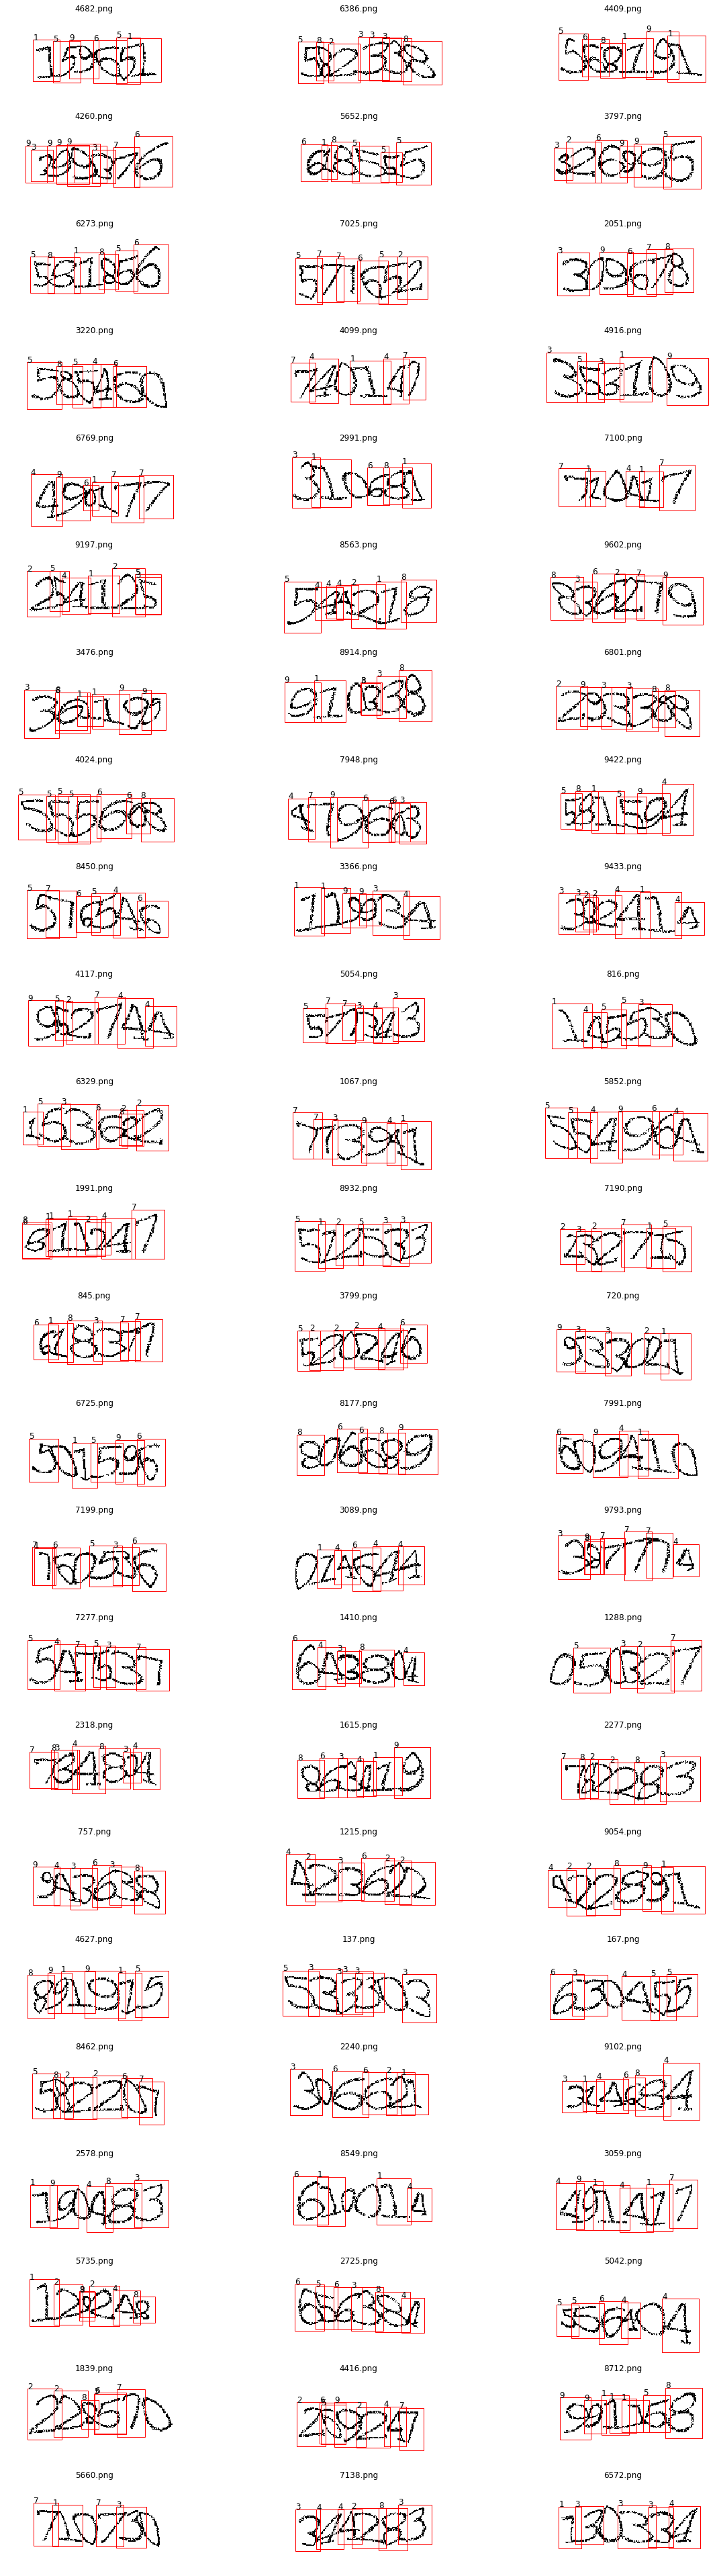

In [32]:
cntr = 0
threshold = 0.5

# Create figure and axes
fig,ax = plt.subplots(24, 3, figsize=(20, 70))

_path = join(path, 'captchas_unlabeled')
for name in test_images[:72]:
    full_name = join(_path, name)
    pred = get_prediction(full_name, model, threshold)
    im = Image.open(full_name) 

    row, col = cntr // 3, cntr % 3
    # Display the image
    ax[row, col].imshow(im)

    # Create a Rectangle patch
    cntr_1 = 0
    for ((x0, y0), (x1, y1)), letter, score in zip(pred[0], pred[1], pred[2]):
#         if cntr_1 == 6:
#             cntr_1 = 0
#             break
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0,y0),w,h,linewidth=1,edgecolor='r',facecolor='none')
        score = '{:.2f}'.format(score)
        ax[row, col].text(x0, y0, f'{letter}', fontsize=12)
        ax[row, col].add_patch(rect)
        ax[row, col].set_title(name)
        cntr_1 += 1
    
    ax[row, col].axis('off')
    cntr += 1
plt.show()

In [34]:
vocab.vocab

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [48]:
train_dataset = CAPTCHADataset(join(path, 'train'), train_df, vocab, simple_transform)
val_dataset = CAPTCHADataset(join(path, 'val'), val_df, vocab, transforms)

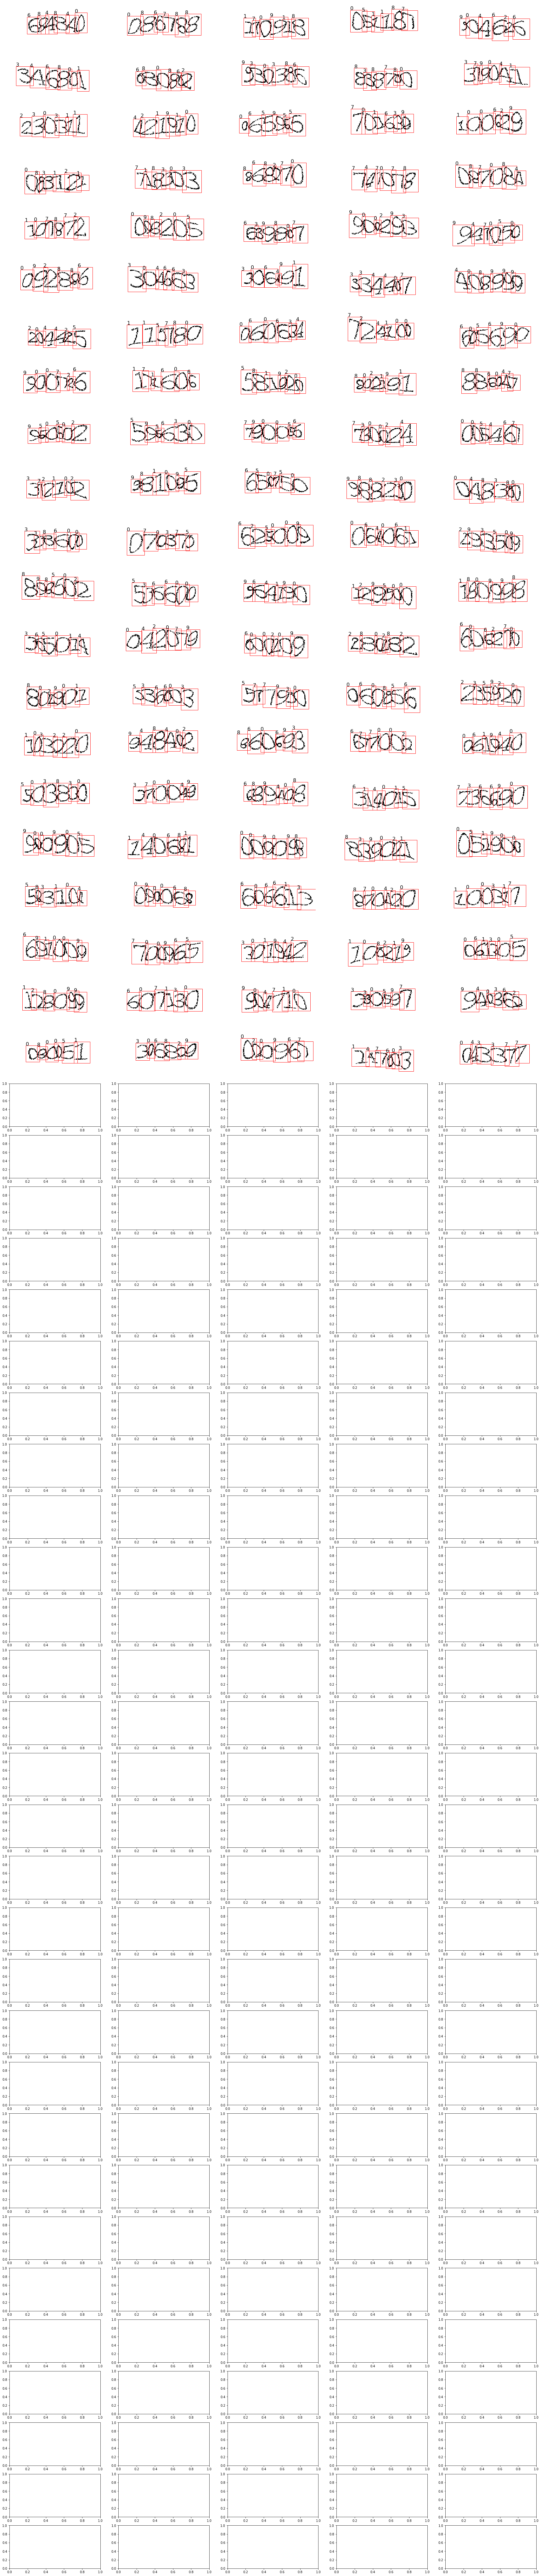

In [75]:
f, ax = plt.subplots(50, 5, figsize=(30, 150))

cntr = 0
for i in range(271):
    img, targets = train_dataset[i]
    boxes, labels = targets['boxes'], targets['labels']
    
    img = img.squeeze().permute(1,2,0).numpy()
    boxes = boxes.numpy()
    labels = labels.numpy()
    
    if len(np.where(labels == 0)[0]) == 0:
        continue
    
    r, c = cntr // 5, cntr % 5
    ax[r][c].imshow(img, cmap='gray')
    
    for (x0, y0, x1, y1), lbl in zip(boxes, labels):
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax[r][c].add_patch(rect)
        ax[r][c].text(x0, y0, lbl, fontsize=16)
        ax[r][c].axis('off')
        
    cntr += 1
    if cntr == 250:
        break
plt.show()

## Mine images which were labeled well by net

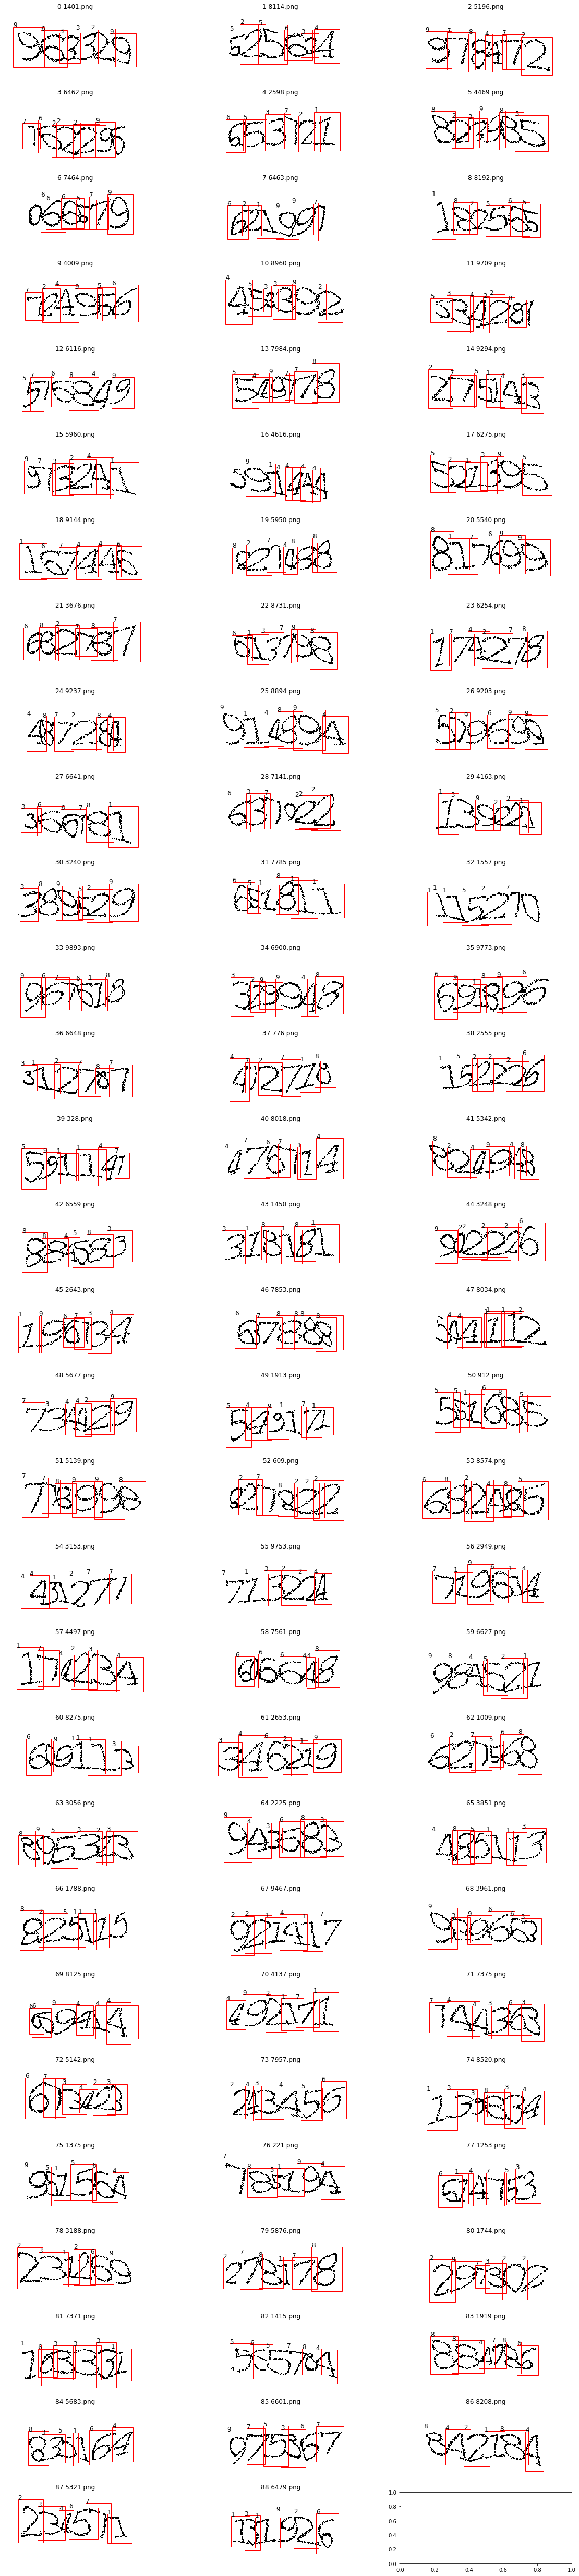

In [41]:
cntr = 0
threshold = 0.9

# Create figure and axes
fig,ax = plt.subplots(30, 3, figsize=(20, 90))

good_images = []

_path = join(path, 'captchas_unlabeled')
# for name in test_images[:400]:
for name in test_images[400:900]:
    full_name = join(_path, name)
    pred = get_prediction(full_name, model, threshold)
    if len(pred[1]) != 6:
        continue
    im = Image.open(full_name) 

    row, col = cntr // 3, cntr % 3
    # Display the image
    ax[row, col].imshow(im)

    # Create a Rectangle patch
    for ((x0, y0), (x1, y1)), letter, score in zip(pred[0], pred[1], pred[2]):
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0,y0),w,h,linewidth=1,edgecolor='r',facecolor='none')
        score = '{:.2f}'.format(score)
        ax[row, col].text(x0, y0, f'{letter}', fontsize=12)
        ax[row, col].add_patch(rect)
        ax[row, col].set_title(f'{len(good_images)} {name}')
    
    good_images.append(name)
    
    ax[row, col].axis('off')
    cntr += 1
plt.show() 

In [44]:
# indices_to_remove = [2,5,8,9,10,13,14,17,20,23,24,26,29,30,40,43,44,46,53,57,62,65,67,72,73,74,75,77,83,85,88,89]
indices_to_remove = [3,6,11,16,28,32,44,46,47,52,54,58,60,66,67,69,74,80,87]

In [45]:
images2use = []
for i in range(len(good_images)):
    if i not in indices_to_remove:
        images2use.append(good_images[i])

In [46]:
with open(join(path, 'images2use.txt'), 'a') as f:
    f.write('\n'.join(images2use))

In [25]:
img_names = [line.strip() for line in open(join(path, 'images2use.txt'), 'r').readlines()]

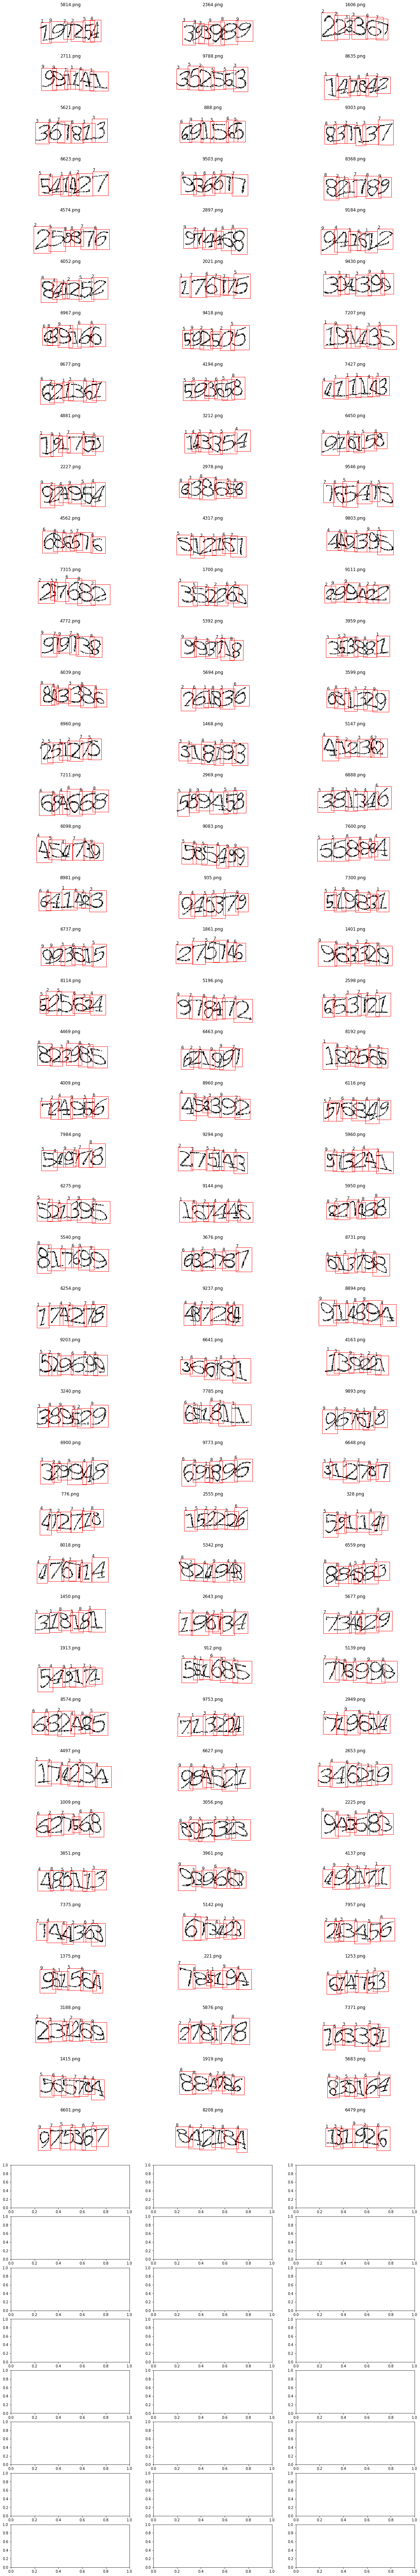

In [26]:
# getting labels
threshold = 0.9
cntr = 0

fig,ax = plt.subplots(50, 3, figsize=(20, 130))

_path = join(path, 'captchas_unlabeled')
for name in img_names:
    full_name = join(_path, name)
    pred = get_prediction(full_name, model, threshold)
    im = Image.open(full_name) 

    row, col = cntr // 3, cntr % 3
    # Display the image
    ax[row, col].imshow(im)

    # Create a Rectangle patch
    for ((x0, y0), (x1, y1)), letter, score in zip(pred[0], pred[1], pred[2]):
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0,y0),w,h,linewidth=1,edgecolor='r',facecolor='none')
        score = '{:.2f}'.format(score)
        ax[row, col].text(x0, y0, f'{letter}', fontsize=12)
        ax[row, col].add_patch(rect)
        ax[row, col].set_title(f'{name}')
        
    ax[row, col].axis('off')
    cntr += 1
plt.show() 

Mining labels

In [27]:
proc_df.head(2)

,img_name,region_id,x0,y0,x1,y1,w,h,label
0,0.png,0,30,26,61,71,31,45,1
1,0.png,1,57,29,81,73,24,44,4


In [30]:
# columns will be the same as in proc_df
df = pd.DataFrame(columns=proc_df.columns)

threshold = 0.9

_path = join(path, 'captchas_unlabeled')
for name in tqdm(img_names):
    full_name = join(_path, name)
    pred = get_prediction(full_name, model, threshold)
    
    boxes, labels, probs = pred[0], pred[1], pred[2]
    
    for i, (((x0, y0), (x1, y1)), lbl) in enumerate(zip(boxes, labels)):
        x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
        d = dict(
            img_name = name,
            region_id = i,
            x0 = x0,
            y0 = y0,
            x1 = x1,
            y1 = y1,
            w = x1 - x0,
            h = y1 - y0,
            label = lbl,
        )
        df = df.append(d, ignore_index=True)

100%|██████████| 126/126 [00:13<00:00,  9.51it/s]


In [32]:
df.head(10)

,img_name,region_id,x0,y0,x1,y1,w,h,label
0,5814.png,0,49,30,92,78,43,48,9
1,5814.png,1,128,27,155,77,27,50,5
2,5814.png,2,101,31,133,76,32,45,2
3,5814.png,3,30,32,54,81,24,49,1
4,5814.png,4,83,32,108,71,25,39,7
5,5814.png,5,146,26,171,77,25,51,4
6,2364.png,0,28,30,58,85,30,55,3
7,2364.png,1,66,36,99,82,33,46,3
8,2364.png,2,117,27,157,84,40,57,8
9,2364.png,3,53,34,79,80,26,46,9


Model has difficulties with recognizing of zero. So there are no zeros in this images. But I manually labeled about 30 images with zeros.

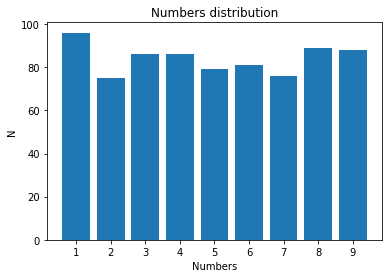

In [33]:
num_freq = df['label'].value_counts()
num_freq = [(k, v) for k, v in zip(num_freq.keys(), num_freq.values)]
num_freq = sorted(num_freq, key=lambda x: x[0])

plt.bar(range(len(num_freq)), [i[1] for i in num_freq], align='center')
plt.xticks(range(len(num_freq)), [i[0] for i in num_freq])
plt.xlabel('Numbers')
plt.ylabel('N')
plt.title('Numbers distribution')
plt.show()

In [35]:
# df.to_csv(join(path, 'captchas_labeled', 'auto_labeled_labels.csv'), index=False)

In [37]:
# for name in df['img_name'].unique():
#     move(join(path, 'captchas_unlabeled', name), join(path, 'captchas_labeled', name))